In [1]:
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy import text

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
database_host='localhost'

In [3]:
def get_connection(host = "localhost",schema="" ):
    
    conn = psycopg2.connect("dbname='proj001_lfb' user='postgres' "
                            "host=" + host )
    if schema:
        cur = conn.cursor()
        query = "SET search_path TO {}".format(schema)
        cur.execute(query)

    return conn

# Create a feature dataset

## Incidents

In [4]:
conn = get_connection(host=database_host)
qry = ("select incidents.*, types.incidentgroup, types.stopcodedescription "
          "from proj001_lfb_1_0_0.l3_incidents incidents "
           "left join "
           "proj001_lfb_1_0_0.l3_incident_types types "
           "on "
           "incidents.id_incident_type = types.id"
          ";")
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_incidents = pd.read_sql(qry, conn)  
conn.close()

# drop some columns that won't be features
df_incidents.drop(['num_stations_with_pumps_attending', 'num_pumps_attending'], axis =1 ,inplace=True)
df_incidents.head()

,id,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,incidentgroup,stopcodedescription
0,1,79398141,2014-06-22 10:21:15,2,24,108386,OVERTHEBORDER,False Alarm,False alarm - Good intent
1,2,168174131,2013-12-07 04:29:07,6,24,108387,OVERTHEBORDER,Fire,Primary Fire
2,3,168954111,2011-10-16 12:20:54,1,32,108388,BROMLEY,False Alarm,AFA
3,4,168866-17122017,2017-12-17 13:06:19,1,29,108388,BROMLEY,False Alarm,AFA
4,5,167600111,2011-10-14 11:58:03,1,24,108388,BROMLEY,False Alarm,AFA


## Postcodes

In [5]:
conn = get_connection(host=database_host)
qry = ('select *'
          'from proj001_lfb_1_0_0.l3_postcodes '
          ';')
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_postcodes = pd.read_sql(qry, conn)  
conn.close()
df_postcodes.head()

,id,postcode_full,postcode_district,incgeo_boroughname,incgeo_wardname,incgeo_wardnamenew,frs
0,1,AL1 3EA,AL1,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
1,2,AL2 1QY,AL2,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
2,3,AL8 7QA,AL8,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
3,4,BR1 1AB,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
4,5,BR1 1AE,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON


Here we discover that fields may need to be stripped of trailing spaces in the pipeline code and that a proportion of the postcodes are unlabelled.

In [6]:
df_empty_pcodes = df_postcodes[df_postcodes['incgeo_boroughname']
             .map(lambda x: x.strip()) == 'NOT GEO-CODED'][['postcode_full','incgeo_boroughname']]['postcode_full'].unique()
print("Unlabeled postcodes: " + str(len(pd.DataFrame(df_empty_pcodes)) ))
print("Total postcodes: " + str(len(df_postcodes) ))

Unlabeled postcodes: 1669
Total postcodes: 110157


In [7]:
df_postcodes.drop(['postcode_district','incgeo_wardname','incgeo_wardnamenew'], inplace=True, axis =1 )
df_postcodes.head(2)

,id,postcode_full,incgeo_boroughname,frs
0,1,AL1 3EA,NOT GEO-CODED,OVERTHEBORDER
1,2,AL2 1QY,NOT GEO-CODED,OVERTHEBORDER


## Property details

In [8]:
conn = get_connection(host=database_host)
qry = ('select *'
          'from proj001_lfb_1_0_0.l3_property '
          ';')
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_property = pd.read_sql(qry, conn)  
conn.close()
df_property.head(3)

,id,propertycategory,propertytype
0,1,Aircraft,Freight plane
1,2,Aircraft,Helicopter
2,3,Aircraft,Light aircraft


# Features dataset
Join together the relevant datasets and drop unnecessary columns.

In [9]:
df_features = pd.merge(pd.merge(df_incidents,df_postcodes,left_on='id_postcode',right_on='id', how='left') , 
                       df_property,left_on='id_property',right_on='id',how='left')
df_features.drop(['id','id_y'], inplace=True, axis =1)
df_features.head()

,id_x,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,incidentgroup,stopcodedescription,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype
0,1,79398141,2014-06-22 10:21:15,2,24,108386,OVERTHEBORDER,False Alarm,False alarm - Good intent,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy
1,2,168174131,2013-12-07 04:29:07,6,24,108387,OVERTHEBORDER,Fire,Primary Fire,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy
2,3,168954111,2011-10-16 12:20:54,1,32,108388,BROMLEY,False Alarm,AFA,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing
3,4,168866-17122017,2017-12-17 13:06:19,1,29,108388,BROMLEY,False Alarm,AFA,None,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys
4,5,167600111,2011-10-14 11:58:03,1,24,108388,BROMLEY,False Alarm,AFA,None,BROMLEY,LONDON,Dwelling,House - single occupancy


Reorder columns into tidydata format

In [10]:
df_features.columns.tolist
cols = ['id_x', 'dateofcall_cln','incidentnumber_cln', 'id_incident_type',
       'id_property', 'id_postcode', 'incident_station_ground',
     'postcode_full',
       'incgeo_boroughname', 'frs', 'propertycategory', 'propertytype', 'incidentgroup','stopcodedescription']
df_features=df_features[cols]
df_features.head()

,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire
2,3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA
3,4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA
4,5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA


# Create the event label
First let's look at the different types of false alarms. AFA is an automatic alarm system. 

In [11]:
df_features[['incidentgroup','stopcodedescription']].drop_duplicates().sort_values(by='incidentgroup')

,incidentgroup,stopcodedescription
0,False Alarm,False alarm - Good intent
2,False Alarm,AFA
65,False Alarm,False alarm - Malicious
1,Fire,Primary Fire
14,Fire,Chimney Fire
571,Fire,Secondary Fire
3127,Fire,Late Call
452853,NULL,NULL
11,Special Service,Special Service
42,Special Service,Flood call attended - Batch mobilised


In [12]:
df_features['is_malicious_false_alarm'] = np.where(df_features['stopcodedescription'] == 'False alarm - Malicious', 1,0)
df_features[['incidentgroup','stopcodedescription','is_malicious_false_alarm']].drop_duplicates().sort_values(by='incidentgroup')

,incidentgroup,stopcodedescription,is_malicious_false_alarm
0,False Alarm,False alarm - Good intent,0
2,False Alarm,AFA,0
65,False Alarm,False alarm - Malicious,1
1,Fire,Primary Fire,0
14,Fire,Chimney Fire,0
571,Fire,Secondary Fire,0
3127,Fire,Late Call,0
452853,NULL,NULL,0
11,Special Service,Special Service,0
42,Special Service,Flood call attended - Batch mobilised,0


# Create derived variables

In [13]:
df_features['incident_month']=df_features['dateofcall_cln'].dt.month
df_features['incident_year']=df_features['dateofcall_cln'].dt.year
df_features['incident_hour']=df_features['dateofcall_cln'].dt.hour
df_features['incident_day']=df_features['dateofcall_cln'].dt.dayofweek

def is_weekend(df):
    """Determine if a callout was at the weekend. By weekend we really mean from Friday evening onwards"""
    
    if df['incident_day'] == 6 or df['incident_day'] == 5:
        return 1
    elif df['incident_day'] == 4 and df['incident_hour']>=18:
        return 1 
    else:
        return 0
    
df_features['is_weekend'] = df_features.apply(is_weekend,axis =1)
print(df_features.dtypes)
df_features.head()

id_x                                 int64
dateofcall_cln              datetime64[ns]
incidentnumber_cln                  object
id_incident_type                     int64
id_property                          int64
id_postcode                          int64
incident_station_ground             object
postcode_full                       object
incgeo_boroughname                  object
frs                                 object
propertycategory                    object
propertytype                        object
incidentgroup                       object
stopcodedescription                 object
is_malicious_false_alarm             int64
incident_month                       int64
incident_year                        int64
incident_hour                        int64
incident_day                         int64
is_weekend                           int64
dtype: object


,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription,is_malicious_false_alarm,incident_month,incident_year,incident_hour,incident_day,is_weekend
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent,0,6,2014,10,6,1
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire,0,12,2013,4,5,1
2,3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,10,2011,12,6,1
3,4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA,0,12,2017,13,6,1
4,5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA,0,10,2011,11,4,0


Weekends or particular times of night might be a good predictor of malicious false alarms.

In [14]:
df_events=df_features.groupby(['is_malicious_false_alarm','incident_day'])['is_malicious_false_alarm'].count()
print(df_events)


is_malicious_false_alarm  incident_day
0                         0               137478
                          1               138125
                          2               136821
                          3               139160
                          4               141587
                          5               146109
                          6               137960
1                         0                 2112
                          1                 2143
                          2                 2081
                          3                 2216
                          4                 2275
                          5                 2542
                          6                 2421
Name: is_malicious_false_alarm, dtype: int64


Here is a sample of when malicious false alarms happen. There seem to be more malicious calls on weekends than during the week.

65     0
105    0
141    3
212    0
247    1
Name: incident_day, dtype: int64


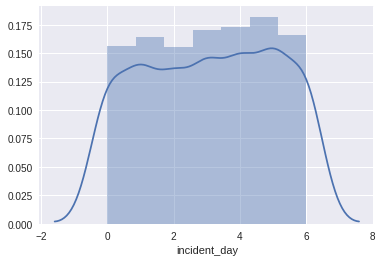

In [15]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==1 ]['incident_day']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

sns.distplot(df_plot, hist=True, rug=False,bins=7);

0    6
1    5
2    6
3    6
4    4
Name: incident_day, dtype: int64


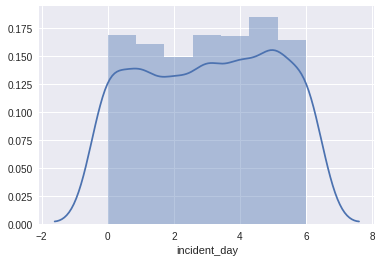

In [16]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==0 ]['incident_day']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

sns.distplot(df_plot, hist=True, rug=False,bins=7);

# Is hour of day a good predictor?
It doesn't seem like hour of day is a good predictor

65      2
105    16
141    19
212    16
247     2
Name: incident_hour, dtype: int64


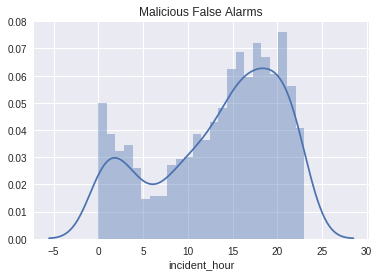

In [17]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==1 ]['incident_hour']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

plt=sns.distplot(df_plot, bins=24,hist=True, rug=False);
plt.set_title('Malicious False Alarms')

0    10
1     4
2    12
3    13
4    11
Name: incident_hour, dtype: int64


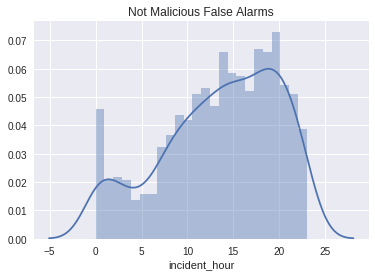

In [18]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==0 ]['incident_hour']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

plt=sns.distplot(df_plot, bins=24,hist=True, rug=False);
plt.set_title('Not Malicious False Alarms')

# Prepare data for modelling

In [45]:
print(df_features.dtypes)
df_features.head(2)

id_x                                 int64
dateofcall_cln              datetime64[ns]
incidentnumber_cln                  object
id_incident_type                     int64
id_property                          int64
id_postcode                          int64
incident_station_ground             object
postcode_full                       object
incgeo_boroughname                  object
frs                                 object
propertycategory                    object
propertytype                        object
incidentgroup                       object
stopcodedescription                 object
is_malicious_false_alarm             int64
incident_month                       int64
incident_year                        int64
incident_hour                        int64
incident_day                         int64
is_weekend                           int64
dtype: object


,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription,is_malicious_false_alarm,incident_month,incident_year,incident_hour,incident_day,is_weekend
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent,0,6,2014,10,6,1
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire,0,12,2013,4,5,1


In [ ]:
df_features_clean = df_features.drop(['id_x','dateofcall_cln','id_incident_type','id_property'])